In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import nbimporter
import time
from OptiEngine import FEM_2D, Config, Timer, optimize

In [2]:
class Timer():
    def __init__(self):
        pass
    
    def start(self):
        self.start_time = time.time()
        
    def end_print(self, print_row):
        end_time = time.time()
        time_passed = round(end_time - self.start_time, 4)
        
        print(f'{print_row} {time_passed} sec')
        
    def time_passed(self):
        end_time = time.time()
        time_passed = round(end_time - self.start_time, 8)
        
        return time_passed

In [3]:
def load_data(path, name_pattern, n_samples):
    pattern = f'{path}\\{name_pattern}_'
    
    # Loading first sample
    samples = np.loadtxt(f'{pattern}{0}_result.txt')
    tasks = np.loadtxt(f'{pattern}{0}_task.txt')
    
    for sample_i in range(1, n_samples):
        new_sample = np.loadtxt(f'{pattern}{sample_i}_result.txt')
        new_task = np.loadtxt(f'{pattern}{sample_i}_task.txt')
        samples = np.concatenate([samples, new_sample], axis = 0)
        tasks = np.concatenate([tasks, new_task], axis = 0)
        
    return (samples.reshape(n_samples, 29, 29), tasks.reshape(n_samples, 30, 30))

In [4]:
def shuffle_data(samples, tasks):
    random_index = np.random.randint(0, samples.shape[0], size = samples.shape[0])
    
    samples_shuffled = samples[random_index]
    tasks_shuffled = tasks[random_index]
    
    return (samples_shuffled, tasks_shuffled)

In [5]:
def binarize_data(samples, threshold):
    for i in range(samples.shape[0]):
        for row in range(29):
            for col in range(29):
                samples[i][row][col] = 0.0 if samples[i][row][col] < threshold else 1.0
    return samples

In [6]:
def gen_batches(samples, tasks, batch_size):
    batches = []
    n_samples = samples.shape[0]
    n_batches = int((n_samples-1) / batch_size)
    
    samples_shuffled, tasks_shuffled = shuffle_data(samples, tasks)
    
    for i in range(n_batches):
        batch_samp = samples_shuffled[i*batch_size]
        batch_task = tasks_shuffled[i*batch_size]
        
        for j in range(1, batch_size):
            batch_samp = np.concatenate((batch_samp, samples_shuffled[i*batch_size + j]), axis = 0)
            batch_task = np.concatenate((batch_task, tasks_shuffled[i*batch_size + j]), axis = 0)
        
        batch_samp = batch_samp.reshape(batch_size, 29, 29)
        batch_task = batch_task.reshape(batch_size, 30, 30)
            
        batches.append((batch_samp, batch_task))
    return batches

In [7]:
class TopologyEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # ENCODER
        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 2, padding = 0)   # 28 x 28 x 16
        self.conv_2 = nn.Conv2d(in_channels = 8, out_channels = 10, kernel_size = 3, padding = 1)  # 28 x 28 x 20
        self.pool_1 = nn.MaxPool2d(kernel_size = 2)                                                 # 14 x 14 x 20
        self.bnorm_1 = nn.BatchNorm2d(10)
        
        self.conv_3 = nn.Conv2d(in_channels = 10, out_channels = 16, kernel_size = 3, padding = 1)  # 14 x 14 x 24
        self.pool_2 = nn.MaxPool2d(kernel_size = 2)                                                 # 7  x 7  x 32                                                            
        
        self.conv_5 = nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = 3, padding = 1)  # 7 x 7 x 16
        # Hidden state
        self.conv_6 = nn.Conv2d(in_channels = 8, out_channels = 2, kernel_size = 3, padding = 1)   # 7 x 7 x 3 
        
        # DECODER
        self.upconv_1 = nn.Conv2d(in_channels = 2, out_channels = 18, kernel_size = 3, padding = 1)  # 7 x 7 x 16
        self.upsample_1 = nn.Upsample(scale_factor = 2)                                              # 14 x 14 x 16
        self.upconv_2 = nn.Conv2d(in_channels = 18, out_channels = 12, kernel_size = 3, padding = 1) # 14 x 14 x 24
        self.upsample_2 = nn.Upsample(scale_factor = 2)                                              # 28 x 28 x 24
        self.upconv_3 = nn.ConvTranspose2d(in_channels = 12, out_channels = 1, kernel_size = 2, padding = 0) # 29 x 29 x 1
        
        self.activ = nn.LeakyReLU(0.2)
        self.flat = nn.Flatten()
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.activ(x)
        x = self.conv_2(x)
        x = self.activ(x)
        x = self.pool_1(x)
        x = self.bnorm_1(x)
        
        x = self.conv_3(x)
        x = self.activ(x)
        x = self.pool_2(x)
        
        x = self.conv_5(x)
        x = self.activ(x)
        x = self.conv_6(x)
        x = self.activ(x)
        
        x = self.flat(x)
        x = x.reshape(-1, 2, 7, 7)
        
        x = self.upconv_1(x)
        x = self.activ(x)
        x = self.upsample_1(x)
        x = self.upconv_2(x)
        x = self.activ(x)
        x = self.upsample_2(x)
        x = self.upconv_3(x)
        
        return x
    
    def hidstate(self, x):
        x = self.conv_1(x)
        x = self.activ(x)
        x = self.conv_2(x)
        x = self.activ(x)
        x = self.pool_1(x)
        x = self.bnorm_1(x)
        
        x = self.conv_3(x)
        x = self.activ(x)
        x = self.pool_2(x)
        
        x = self.conv_5(x)
        x = self.activ(x)
        x = self.conv_6(x)
        
        x = self.flat(x)
        
        return x
    
    def gen_from_hidstate(self, hs):
        x = hs.reshape(-1, 2, 7, 7)
        x = self.upconv_1(x)
        x = self.activ(x)
        x = self.upsample_1(x)
        x = self.upconv_2(x)
        x = self.activ(x)
        x = self.upsample_2(x)
        x = self.upconv_3(x)
        
        return x

In [19]:
class HidstatePredictor(nn.Module):
    def __init__(self):
        super().__init__()
         
        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, padding = 0) # 28
        self.conv_2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1) # 28
        self.pool_1 = nn.MaxPool2d(kernel_size = 2) # 14
        
        self.conv_3 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, padding = 1) # 14
        self.pool_2 = nn.MaxPool2d(kernel_size = 2) # 7
        
        self.linear_1 = nn.Linear(in_features = 7*7*16, out_features = 1024)
        self.linear_2 = nn.Linear(in_features = 1024, out_features = 2048)
        self.linear_3 = nn.Linear(in_features = 2048, out_features = 1024)
        self.linear_4 = nn.Linear(in_features = 1024, out_features = 49*2)
        
        self.flat = nn.Flatten()
        self.activ = nn.LeakyReLU(0.15)
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.activ(x)
        x = self.conv_2(x)
        x = self.activ(x)
        x = self.pool_1(x)
        
        x = self.conv_3(x)
        x = self.activ(x)
        x = self.pool_2(x)
        
        x = self.flat(x)
        
        x = self.linear_1(x)
        x = self.activ(x)
        x = self.linear_2(x)
        x = self.activ(x)
        x = self.linear_3(x)
        x = self.activ(x)
        x = self.linear_4(x)
        
        return x

In [9]:
def train_encoder(model, n_epochs, learning_rate, origin_samples, origin_tasks, batch_size):
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    loss_func = nn.MSELoss()
    
    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1}. Lr = {learning_rate:.3e}')
        for batch in gen_batches(origin_samples, origin_tasks, batch_size):
            samples, tasks = batch
            
            samples = torch.FloatTensor(samples).reshape(-1,1,29,29)
            
            samples_pred = model(samples)
            loss = loss_func(samples_pred, samples)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [10]:
def train_hidstater(model, encoder, n_epochs, learning_rate, origin_samples, origin_tasks, batch_size):
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    loss_func = nn.MSELoss()
    
    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}. Lr = {learning_rate:.3e}')
        for batch in gen_batches(origin_samples, origin_tasks, batch_size):
            samples, tasks = batch
            
            samples = torch.FloatTensor(samples).reshape(-1,1,29,29)
            tasks = torch.FloatTensor(tasks).reshape(-1, 1, 30, 30)
            
            hidstates = encoder.hidstate(samples)
            pred = model(tasks)
            
            loss = loss_func(pred, hidstates)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [11]:
path = 'C:\\Users\\mihai\\Desktop\\Unik\\4 курс\\Оптимизация\\Train_Data\\Square_Bucket_1'
name_pattern = 'bucket1'
n_samples = 2640

In [12]:
samples, tasks = load_data(path, name_pattern, n_samples)

In [13]:
samples = binarize_data(samples, 0.4)

Sample optimized topology:


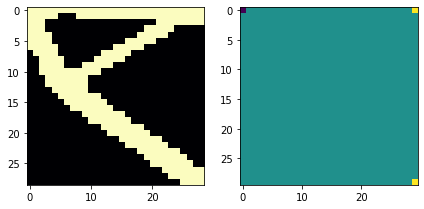

In [14]:
fig, axes = plt.subplots(1,2, figsize = (7,7))
i = 0
axes[0].imshow(samples[i], interpolation = 'none', cmap = 'magma')
axes[1].imshow(tasks[i])
print('Sample optimized topology:')

In [15]:
encoder = TopologyEncoder()

In [20]:
hidstater = HidstatePredictor()

In [17]:
train_encoder(encoder, 80, 1e-3, samples, tasks, 32)

Epoch 1. Lr = 1.000e-03
Epoch 2. Lr = 1.000e-03
Epoch 3. Lr = 1.000e-03
Epoch 4. Lr = 1.000e-03
Epoch 5. Lr = 1.000e-03
Epoch 6. Lr = 1.000e-03
Epoch 7. Lr = 1.000e-03
Epoch 8. Lr = 1.000e-03
Epoch 9. Lr = 1.000e-03
Epoch 10. Lr = 1.000e-03
Epoch 11. Lr = 1.000e-03
Epoch 12. Lr = 1.000e-03
Epoch 13. Lr = 1.000e-03
Epoch 14. Lr = 1.000e-03
Epoch 15. Lr = 1.000e-03
Epoch 16. Lr = 1.000e-03
Epoch 17. Lr = 1.000e-03
Epoch 18. Lr = 1.000e-03
Epoch 19. Lr = 1.000e-03
Epoch 20. Lr = 1.000e-03
Epoch 21. Lr = 1.000e-03
Epoch 22. Lr = 1.000e-03
Epoch 23. Lr = 1.000e-03
Epoch 24. Lr = 1.000e-03
Epoch 25. Lr = 1.000e-03
Epoch 26. Lr = 1.000e-03
Epoch 27. Lr = 1.000e-03
Epoch 28. Lr = 1.000e-03
Epoch 29. Lr = 1.000e-03
Epoch 30. Lr = 1.000e-03
Epoch 31. Lr = 1.000e-03
Epoch 32. Lr = 1.000e-03
Epoch 33. Lr = 1.000e-03
Epoch 34. Lr = 1.000e-03
Epoch 35. Lr = 1.000e-03
Epoch 36. Lr = 1.000e-03
Epoch 37. Lr = 1.000e-03
Epoch 38. Lr = 1.000e-03
Epoch 39. Lr = 1.000e-03
Epoch 40. Lr = 1.000e-03
Epoch 41.

In [21]:
train_hidstater(hidstater, encoder, 40, 1e-3, samples, tasks, 32)

Epoch 1. Lr = 1.000e-03
Epoch 2. Lr = 1.000e-03
Epoch 3. Lr = 1.000e-03
Epoch 4. Lr = 1.000e-03
Epoch 5. Lr = 1.000e-03
Epoch 6. Lr = 1.000e-03
Epoch 7. Lr = 1.000e-03
Epoch 8. Lr = 1.000e-03
Epoch 9. Lr = 1.000e-03
Epoch 10. Lr = 1.000e-03
Epoch 11. Lr = 1.000e-03
Epoch 12. Lr = 1.000e-03
Epoch 13. Lr = 1.000e-03
Epoch 14. Lr = 1.000e-03
Epoch 15. Lr = 1.000e-03
Epoch 16. Lr = 1.000e-03
Epoch 17. Lr = 1.000e-03
Epoch 18. Lr = 1.000e-03
Epoch 19. Lr = 1.000e-03
Epoch 20. Lr = 1.000e-03
Epoch 21. Lr = 1.000e-03
Epoch 22. Lr = 1.000e-03
Epoch 23. Lr = 1.000e-03
Epoch 24. Lr = 1.000e-03
Epoch 25. Lr = 1.000e-03
Epoch 26. Lr = 1.000e-03
Epoch 27. Lr = 1.000e-03
Epoch 28. Lr = 1.000e-03
Epoch 29. Lr = 1.000e-03
Epoch 30. Lr = 1.000e-03
Epoch 31. Lr = 1.000e-03
Epoch 32. Lr = 1.000e-03
Epoch 33. Lr = 1.000e-03
Epoch 34. Lr = 1.000e-03
Epoch 35. Lr = 1.000e-03
Epoch 36. Lr = 1.000e-03
Epoch 37. Lr = 1.000e-03
Epoch 38. Lr = 1.000e-03
Epoch 39. Lr = 1.000e-03
Epoch 40. Lr = 1.000e-03


Neural Network design time:  0.002 sec


Text(0.5, 1.0, 'NN solution')

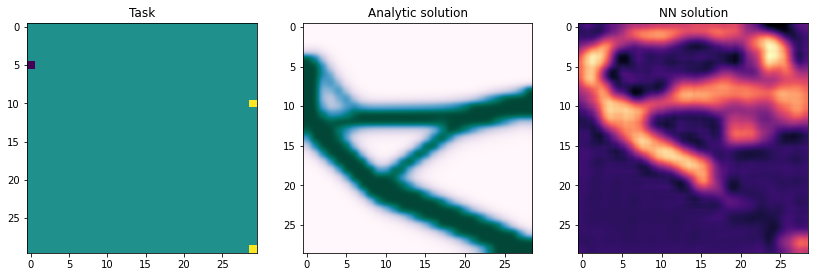

In [22]:
custom_task = np.zeros((30, 30))
custom_task[5][0] = -1
custom_task[10][29] = 1
custom_task[29][29] = 1

config = Config()

nx = 30
ny = 30

config.nx = nx
config.ny = ny

config.vol_frac = 0.3
config.penalize = 3

config.dense_delta = 0.01
config.max_iter = 40

config.E0 = 1
config.E_void = 1e-9

config.filter_r = 1.5
config.move = 0.2

config.fem_save_iters = [1]

FEM_solver = FEM_2D(config.nx, config.ny, config.filter_r)

FEM_solver.fix_node(10, 29, True, True)
FEM_solver.fix_node(29, 29, True, True)
FEM_solver.apply_load(5, 0, 0, -1)

FEM_solver.form_elements()
config.H, config.sH = FEM_solver.prepare_filter()
xPhys_opt = optimize(FEM_solver, config, False, False)

ey = ny - 1
ex = nx - 1

x_matrix = np.zeros((ey, ex))
for col in range(ex):
    for row in range(ey):
        x_matrix[row][col] = xPhys_opt[col*ey + row]

fig, axes = plt.subplots(1, 3, figsize = (14,14))
axes[0].imshow(custom_task)
axes[0].set_title('Task')

axes[1].imshow(x_matrix, interpolation = 'gaussian', cmap = 'PuBuGn')
axes[1].set_title('Analytic solution')

timer = Timer()
timer.start()

hidstate_predict = hidstater(torch.FloatTensor(custom_task).reshape((1,1,30,30))).detach()
nn_design = encoder.gen_from_hidstate(hidstate_predict).reshape((29,29)).detach()
timer.end_print('Neural Network design time: ')
axes[2].imshow(nn_design, interpolation = 'bessel', cmap = 'magma')
axes[2].set_title('NN solution')

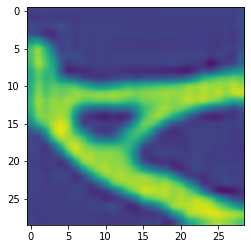

In [23]:
test = encoder(torch.FloatTensor(x_matrix).reshape(1,1,29,29)).detach().reshape(29,29)
plt.imshow(test, interpolation = 'gaussian')

Neural Network design time:  0.0084 sec


Text(0.5, 1.0, 'NN solution')

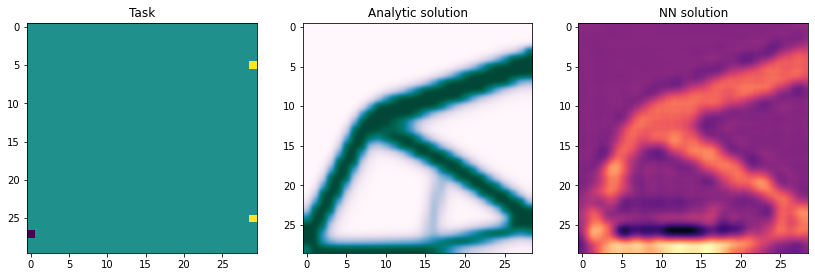

In [29]:
custom_task = np.zeros((30, 30))
custom_task[27][0] = -1
custom_task[5][29] = 1
custom_task[25][29] = 1

config = Config()

nx = 30
ny = 30

config.nx = nx
config.ny = ny

config.vol_frac = 0.3
config.penalize = 3

config.dense_delta = 0.01
config.max_iter = 40

config.E0 = 1
config.E_void = 1e-9

config.filter_r = 1.5
config.move = 0.2

config.fem_save_iters = [1]

FEM_solver = FEM_2D(config.nx, config.ny, config.filter_r)

FEM_solver.fix_node(5, 29, True, True)
FEM_solver.fix_node(25, 29, True, True)
FEM_solver.apply_load(27, 0, 0, -1)

FEM_solver.form_elements()
config.H, config.sH = FEM_solver.prepare_filter()
xPhys_opt = optimize(FEM_solver, config, False, False)

ey = ny - 1
ex = nx - 1

x_matrix = np.zeros((ey, ex))
for col in range(ex):
    for row in range(ey):
        x_matrix[row][col] = xPhys_opt[col*ey + row]

fig, axes = plt.subplots(1, 3, figsize = (14,14))
axes[0].imshow(custom_task)
axes[0].set_title('Task')

axes[1].imshow(x_matrix, interpolation = 'gaussian', cmap = 'PuBuGn')
axes[1].set_title('Analytic solution')

timer = Timer()
timer.start()

hidstate_predict = hidstater(torch.FloatTensor(custom_task).reshape((1,1,30,30))).detach()
nn_design = encoder.gen_from_hidstate(hidstate_predict).reshape((29,29)).detach()
timer.end_print('Neural Network design time: ')
axes[2].imshow(nn_design, interpolation = 'bessel', cmap = 'magma')
axes[2].set_title('NN solution')